<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/Fruit_360_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit 360 Dataset

# 1: About the Dataset

Total number of images: 90483.

Training set size: 67692 images (one fruit or vegetable per image).

Test set size: 22688 images (one fruit or vegetable per image).

Number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.

Filename format: imageindex100.jpg (e.g. 32100.jpg) or rimageindex100.jpg (e.g. r32100.jpg) or r2imageindex100.jpg or r3imageindex100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

2: Data Pre Processing

Since we are using PyTorch to build the neural network. I import all the related library in single go.

In [36]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 2: Data Pre Processing

## 2.1 Downloading the dataset

In [2]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Saving kaggle.json to kaggle.json


  0%|          | 3.00M/760M [00:00<00:27, 28.9MB/s]

100%|██████████| 760M/760M [00:08<00:00, 91.7MB/s]


Before we run any exploration the dataset has to be loaded to a dataloader

In [37]:
data_dir = '/content/fruits/fruits-360/'

dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

Testing = ImageFolder(data_dir + "Test", transform=ToTensor())

# 3: Exploring the dataset

## Q: How many images does the training and testing dataset contain?

In [38]:
dataset_size = len(dataset)
test_dataset_size = len(Testing)
print(dataset)
print(Testing)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/fruits/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /content/fruits/fruits-360/Test
    StandardTransform
Transform: ToTensor()


## Q: How many output classes does the dataset contain?

In [39]:
# Accesssing the classes
data_dir = '/content/fruits/fruits-360/'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "Test")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classe 131
Classes Names: ['Corn Husk', 'Guava', 'Apple Pink Lady', 'Watermelon', 'Cherry 2', 'Banana Lady Finger', 'Onion White', 'Quince', 'Kumquats', 'Apple Red 3', 'Nut Forest', 'Pear Monster', 'Pear 2', 'Blueberry', 'Pear Forelle', 'Maracuja', 'Peach Flat', 'Grape White 3', 'Cantaloupe 1', 'Corn', 'Cocos', 'Tomato not Ripened', 'Grape White 4', 'Apple Red 1', 'Lemon', 'Pineapple', 'Ginger Root', 'Apricot', 'Salak', 'Cherry Rainier', 'Potato Red', 'Pear Kaiser', 'Apple Crimson Snow', 'Apple Red Delicious', 'Mangostan', 'Peach', 'Pear Stone', 'Lemon Meyer', 'Clementine', 'Papaya', 'Eggplant', 'Rambutan', 'Mango Red', 'Banana Red', 'Avocado ripe', 'Raspberry', 'Pepper Yellow', 'Onion Red', 'Kohlrabi', 'Passion Fruit', 'Pear Red', 'Avocado', 'Grape White 2', 'Pepper Green', 'Pepper Orange', 'Redcurrant', 'Grape Pink', 'Tomato Yellow', 'Tomato Maroon', 'Pomegranate', 'Huckleberry', 'Mango', 'Grapefruit White', 'Potato White', 'Mandarine', 'Nectarine Flat', 'Grape Blue',

## Q: What is the shape of an image tensor from the dataset?

In [41]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

Let us print a sample image along with its class and label.

Label (numeric): 0
Label (textual): Corn Husk


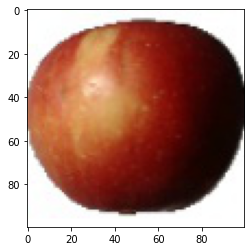

In [42]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

## Q: Can you determine the number of images belonging to each class?

In [43]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'Apple Braeburn': 492,
 'Apple Crimson Snow': 444,
 'Apple Golden 1': 480,
 'Apple Golden 2': 492,
 'Apple Golden 3': 481,
 'Apple Granny Smith': 492,
 'Apple Pink Lady': 456,
 'Apple Red 1': 492,
 'Apple Red 2': 492,
 'Apple Red 3': 429,
 'Apple Red Delicious': 490,
 'Apple Red Yellow 1': 492,
 'Apple Red Yellow 2': 672,
 'Apricot': 492,
 'Avocado': 427,
 'Avocado ripe': 491,
 'Banana': 490,
 'Banana Lady Finger': 450,
 'Banana Red': 490,
 'Beetroot': 450,
 'Blueberry': 462,
 'Cactus fruit': 490,
 'Cantaloupe 1': 492,
 'Cantaloupe 2': 492,
 'Carambula': 490,
 'Cauliflower': 702,
 'Cherry 1': 492,
 'Cherry 2': 738,
 'Cherry Rainier': 738,
 'Cherry Wax Black': 492,
 'Cherry Wax Red': 492,
 'Cherry Wax Yellow': 492,
 'Chestnut': 450,
 'Clementine': 490,
 'Cocos': 490,
 'Corn': 450,
 'Corn Husk': 462,
 'Cucumber Ripe': 392,
 'Cucumber Ripe 2': 468,
 'Dates': 490,
 'Eggplant': 468,
 'Fig': 702,
 'Ginger Root': 297,
 'Granadilla': 490,
 'Grape Blue': 984,
 'Grape Pink': 492,
 'Grape White'